### House_price_prediction 

프로젝트 루브릭

- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
- 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?


### 목차
1. 데이터 탐색
2. 데이터 전처리
3. 모델링
4. 하이퍼 파라미터 튜닝
5. 학습 및 예측결과 생성

## 1. 데이터 탐색

- 문제 정의 : 집의 정보를 가지고 가격 예측하는 회귀문제

In [1]:
# 필요한 모듈 import
import warnings
warnings.filterwarnings('ignore')

import os
from os.path import join

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt # 시각화
import seaborn as sns

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

%matplotlib inline
import gc

# 데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('good')

good


- 변수 설명

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [2]:
train.head() # 데이터 확인

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [3]:
# 변수 시각화
train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

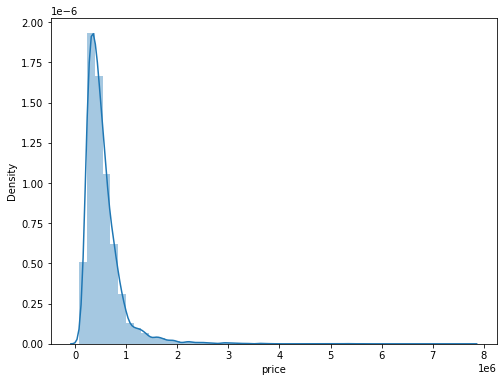

In [4]:
f, ax = plt.subplots(figsize=(8, 6)) # 히스토그램
sns.distplot(train['price'])

<AxesSubplot:xlabel='price', ylabel='Density'>

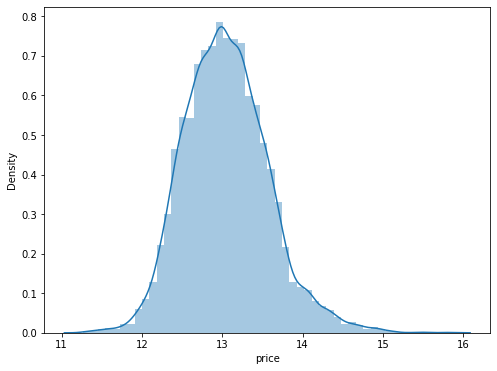

In [5]:
# price 변수 정규분포화
train['price'] = np.log1p(train['price'])
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['price'])

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

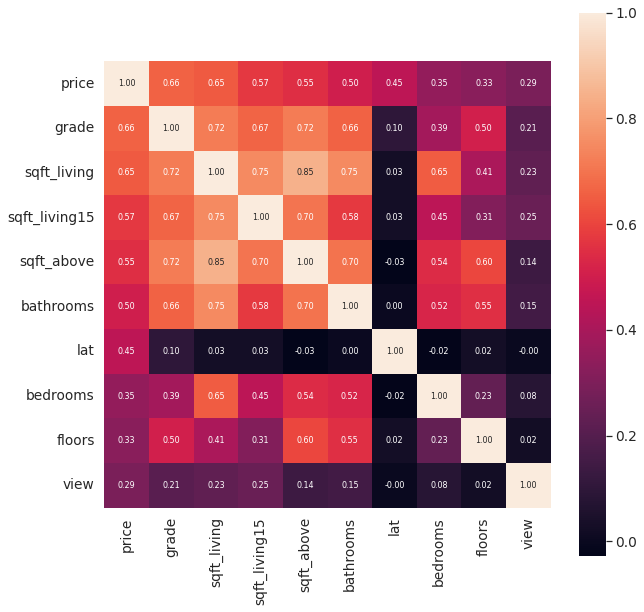

In [6]:
# price랑 가장 상관관계가 높은 순서대로 스피어만 순위 상관관계를 본 히트맵
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10

print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

grade - sqft - bethroom - lat - bedrooms - floors - view
lat이 있는 이유는 위 지역이 시애틀인데 시애틀은 북쪽으로 갈수록 살기 좋은 집들이 많다고 함(discussion 참고)

## 2. 데이터 전처리

- 이상치를 제거해보자

In [7]:
# 결측값 확인
train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

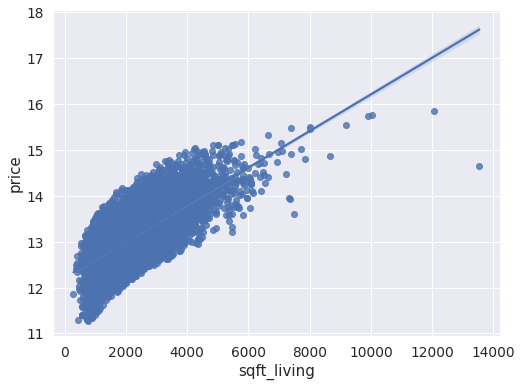

In [8]:
# sqft_living
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [9]:
train.loc[train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


다른값들에 비해 sqft_living만 비정상적으로 크기 때문에 제거

In [10]:
train = train.loc[train['id']!=8912]

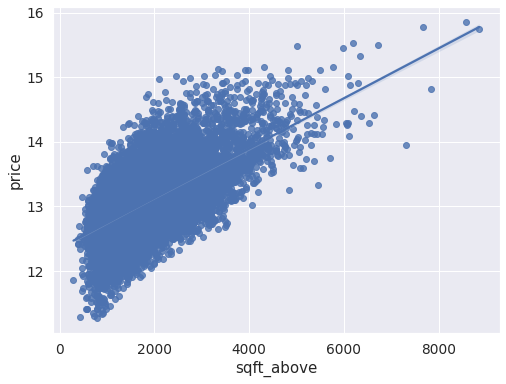

In [11]:
# sqft_above
data = pd.concat([train['price'], train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y='price', data = data)

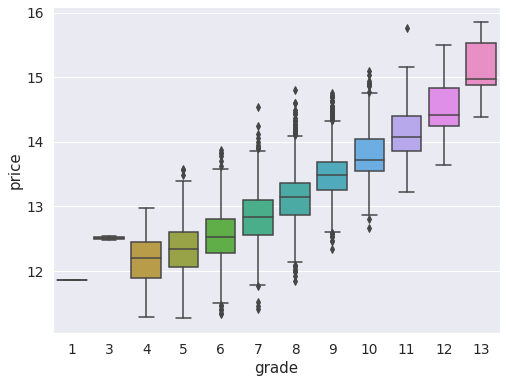

In [12]:
# grade
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

grade 3, 7, 8, 11이 특이함

In [13]:
train.loc[(train['price']>12) & (train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [14]:
train.loc[(train['price']<11.7) & (train['grade'] == 7)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
878,878,20140717T000000,11.512935,2,1.0,770,17334,1.0,0,0,...,7,770,0,1978,0,98001,47.2997,-122.269,1480,17334
2372,2372,20141212T000000,11.461643,2,1.0,800,8550,1.0,0,0,...,7,800,0,1947,0,98198,47.4075,-122.294,1490,8550
8756,8756,20140513T000000,11.407576,2,1.0,790,2640,1.0,0,0,...,7,790,0,1973,0,98034,47.7351,-122.178,1310,2064


In [15]:
train.loc[(train['price']>14.5) & (train['grade'] == 7)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12346,12346,20150115T000000,14.533351,4,3.25,3580,19989,1.5,1,4,...,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389


In [16]:
train.loc[(train['price']>14.5) & (train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
983,983,20150511T000000,14.603968,5,4.25,4640,22703,2.0,1,4,...,8,2860,1780,1952,0,98052,47.6393,-122.097,3140,14200
7173,7173,20140813T000000,14.808763,5,4.00,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295
10037,10037,20140825T000000,14.603968,3,2.00,3570,30456,1.0,0,1,...,8,2070,1500,1946,1982,98039,47.6413,-122.240,3570,27418


In [17]:
train.loc[(train['price']>15.5) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


특별한 이유없이 높아보이거나 이상한 데이터는 제거하자

In [18]:
train = train.loc[train['id']!=2302]
train = train.loc[train['id']!=4123]
train = train.loc[train['id']!=878]
train = train.loc[train['id']!=2372]
train = train.loc[train['id']!=8756]
train = train.loc[train['id']!=12346]
#train = train.loc[train['id']!=983]
train = train.loc[train['id']!=7173]
#train = train.loc[train['id']!=10037]
train = train.loc[train['id']!=2775]

print(len(train['id']))

15026


In [19]:
# sqft 정규화해보자
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

In [20]:
for df in [train,test]:
    df['date'] = df['date'].apply(lambda x: x[0:8])
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [21]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,2238,6819
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,1650,9711


In [22]:
# date 처리(년월을 숫자로 변환)
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650
1,1,201502,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062
2,2,201502,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503
3,3,201406,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,2238,6819
4,4,201501,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,1650,9711


In [23]:
print(train['waterfront'].unique())
print(train['view'].unique())
print(train['condition'].unique())

[0 1]
[0 3 4 2 1]
[3 4 5 2 1]


In [24]:
# price 컬럼 y에 넣어두고 삭제
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [25]:
# id 컬럼 삭제
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [26]:
# test 데이터도 같은 작업 진행, price는 없어서 안 해도 됨
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [27]:
# 타겟 데이터 확인
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15026, dtype: float64

In [28]:
train.info() # 인포 함수로 자료형 확인

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15026 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15026 non-null  int64  
 1   bedrooms       15026 non-null  int64  
 2   bathrooms      15026 non-null  float64
 3   sqft_living    15026 non-null  float64
 4   sqft_lot       15026 non-null  float64
 5   floors         15026 non-null  float64
 6   waterfront     15026 non-null  int64  
 7   view           15026 non-null  int64  
 8   condition      15026 non-null  int64  
 9   grade          15026 non-null  int64  
 10  sqft_above     15026 non-null  float64
 11  sqft_basement  15026 non-null  float64
 12  yr_built       15026 non-null  int64  
 13  yr_renovated   15026 non-null  float64
 14  zipcode        15026 non-null  int64  
 15  lat            15026 non-null  float64
 16  long           15026 non-null  float64
 17  sqft_living15  15026 non-null  int64  
 18  sqft_l

### 3. 모델링

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [30]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [31]:
# 네가지 모델 가져오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [32]:
# get score 함수 생성 (모델 RMSE값 얻는 함수)
def get_scores(models, train, y):
    df = {}
    for model in models:
        # 모델이름 획득
        model_name = model.__class__.__name__
        # train, test 데이터셋 분리 - 여기에도 random_state를 고정
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        # 학습
        model.fit(X_train, y_train)
        # 예측
        y_pred = model.predict(X_test)
        # 예측결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

In [33]:
random_state=2020        # 고정값 세팅

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

get_scores(models, train, y)

,RMSE
RandomForestRegressor,153649.752590
GradientBoostingRegressor,146919.591430
LGBMRegressor,136599.904584
XGBRegressor,136244.656402


### 4. 하이퍼 파라미터 튜닝

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])  # rmse: 평균제곱근오차
    results = results.rename(columns={'RMSE': 'RMSLE'})
    results = results.sort_values('RMSLE')  # `RMSLE`가 낮은 순서대로 정렬

    return results

In [36]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'learning_rate': [0.005],
    'num_iteration': [10000],
    'num_leaves': [30],
    'min_data_in_leaf': [20],
    'feature_fraction': [0.8],
    'boosting': ['gbdt'],
    'objective':['regression'],
    'num_boost_round':[5000],
    'metric':['rmse']
}

model = LGBMRegressor(random_state=random_state)

my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
# 0.159174

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it

[LightGBM] [Warning] num_iterations is set with num_boost_round=5000, will be overridden by num_iteration=10000. Current value: num_iterations=10000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] num_iterations is set=10000, num_iteration=10000 will be ignored. Current value: num_iterations=10000


,boosting,feature_fraction,learning_rate,max_depth,metric,min_data_in_leaf,n_estimators,num_boost_round,num_iteration,num_leaves,objective,score,RMSLE
0,gbdt,0.8,0.005,10,rmse,20,100,5000,10000,30,regression,-0.025343,0.159194


In [37]:
model_lgb = LGBMRegressor(
    n_estimators=100,
    max_depth=-1,
    learning_rate=0.005,
    num_iteration=10000,
    num_leaves=30,
    min_data_in_leaf=20,
    feature_fraction=0.8,
    boosting='gbdt',
    objective='regression',
    num_boost_round=5000,
    metric='rmse',
    random_state=random_state)

model_xgb = XGBRegressor(
    eta=0.02,
    max_depth=30,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:linear',    
    eval_metric='rmse',        
    seed=1984
)

In [38]:
from sklearn.model_selection import KFold, cross_val_score
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


score = rmsle_cv(model_lgb)
lgb_score = score.mean()
print("LGBMRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb)
xgb_score = score.mean()
print("XGBRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

[LightGBM] [Warning] num_iterations is set with num_boost_round=5000, will be overridden by num_iteration=10000. Current value: num_iterations=10000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] num_iterations is set=10000, num_iteration=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] num_iterations is set with num_boost_round=5000, will be overridden by num_iteration=10000. Current value: num_iterations=10000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boostin

In [39]:
model_xgb.fit(train, y)
model_lgb.fit(train, y)

pred_xgb = model_xgb.predict(test)
pred_lgb = model_lgb.predict(test)

pred_xgb = np.expm1(pred_xgb)
pred_lgb = np.expm1(pred_lgb)

[09:40:42] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] num_iterations is set with num_boost_round=5000, will be overridden by num_iteration=10000. Current value: num_iterations=10000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] num_iterations is set=10000, num_iteration=10000 will be ignored. Current value: num_iterations=10000


In [40]:
ensemble_pred = np.vstack([pred_lgb, pred_xgb]).mean(0)

In [41]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    
# csv에 쓰기
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = ensemble_pred
submission_csv_path = '{}/submission_ensemble_xgb_lgb.csv'.format(data_dir)
submission.to_csv(submission_csv_path, index=False)
print('{} saved!'.format(submission_csv_path))

/aiffel/aiffel/kaggle_kakr_housing/data/submission_ensemble_xgb_lgb.csv saved!


### 5. 학습 및 예측 결과 생성

In [42]:
param_grid = {
    'n_estimators': 100,
    'max_depth': -1,
    'learning_rate': 0.005,
    'num_iteration': 10000,
    'num_leaves': 30,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'boosting': 'gbdt',
    'objective':'regression',
    'num_boost_round':5000,
    'metric':'rmse'
}

model = LGBMRegressor(**param_grid)

In [43]:
def save_submission(model, train, y, test, model_name, rmsle):
    # 위에 나온 결과로 학습 및 예측 결과 생성
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)  # 원래 스케일로 되돌림
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    
    # csv에 쓰기
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [44]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.159174')

[LightGBM] [Warning] num_iterations is set with num_iteration=10000, num_boost_round=5000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] num_iterations is set=10000, num_iteration=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.159174.csv saved!


Private Score : 110178.21159
Public Score: 108127.83322